In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from PIL import Image
import tifffile
import napari
from matplotlib import pyplot as plt
from skvideo import io as skvideo_io

In [66]:
from seghub.classif_utils import get_kmeans_clusters, get_pca_features
from seghub.vgg16_utils import get_vgg16_features_targets, get_vgg16_feature_space
from seghub.dino_utils import get_dinov2_patch_features, get_dinov2_pixel_features, get_dinov2_features_targets, get_dinov2_feature_space
from seghub.ilastik_utils import get_ila_features_targets, get_ila_feature_space
from seghub.rf_utils import train_seg_forest, predict_seg_forest_single_image, predict_seg_forest

In [259]:
shark_vid = skvideo_io.vread("../data/shark_test_vid.AVI")
print(shark_vid.shape)

(744, 480, 640, 3)


In [260]:
img = shark_vid[0] / 255
# img = img[:,:,0]
print(img.shape)

(480, 640, 3)


In [261]:
v = napari.view_image(img)

In [262]:
# labels = v.layers['Labels'].data
# tifffile.imsave("../data/shark_vid_labels_frame0.tif", labels.astype(np.uint8))

labels = tifffile.imread("../data/shark_vid_labels_frame0.tif")
print(labels.shape)
print(np.sum(labels > 0))

(480, 640)
2480


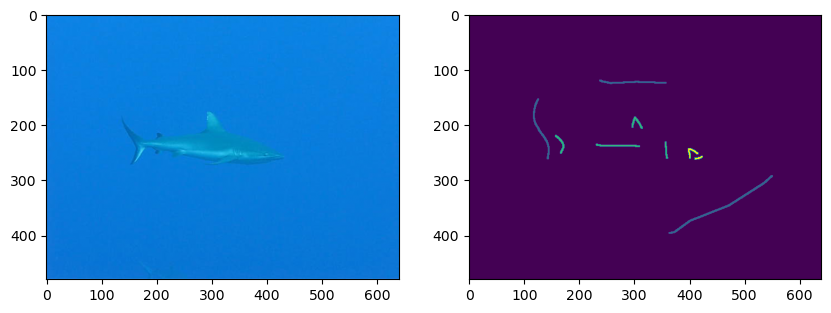

In [263]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img)
ax[1].imshow(labels)

## VGG16 (Convpaint)

In [264]:
feature_space = get_vgg16_feature_space(img, layer_list=[0], scalings=[1,2], model_name="vgg16")
print(feature_space.shape)

Using RGB
(480, 640, 128)


In [265]:
# Because of edge problems in the current version of convpaint, we exclude the edge features
overall_means = np.mean(np.mean(feature_space, axis=0),axis=0)
feature_space[:5] = overall_means
feature_space[-5:] = overall_means
feature_space[:,:5] = overall_means
feature_space[:,-5:] = overall_means

In [266]:
v.add_image(np.moveaxis(feature_space, -1, 0), name="Feature Space VGG16")

<Image layer 'Feature Space VGG16' at 0x2053e703eb0>

In [267]:
kmeans_f = get_kmeans_clusters(feature_space, num_clusters=2)
print(kmeans_f.shape)

(480, 640)


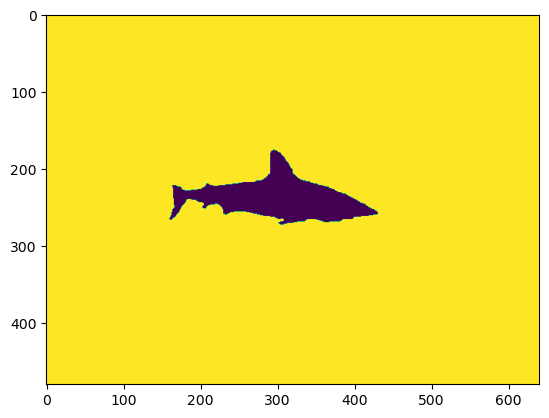

In [268]:
plt.imshow(kmeans_f)

In [269]:
pc = get_pca_features(feature_space, num_components=10)
print(pc.shape)

(480, 640, 10)


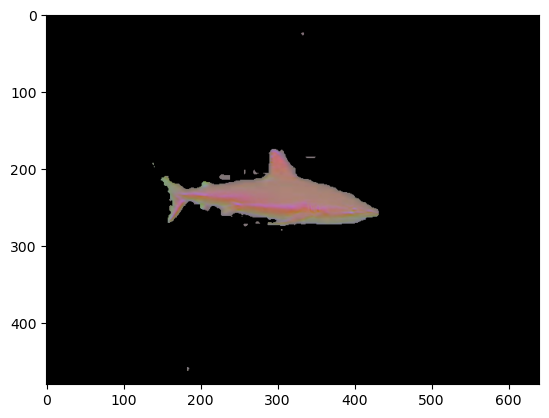

In [270]:
three_pc = pc[:,:,:3].copy()
pc_mask = pc[:,:,0]<0.5
three_pc[pc_mask] = 0
plt.imshow(three_pc)

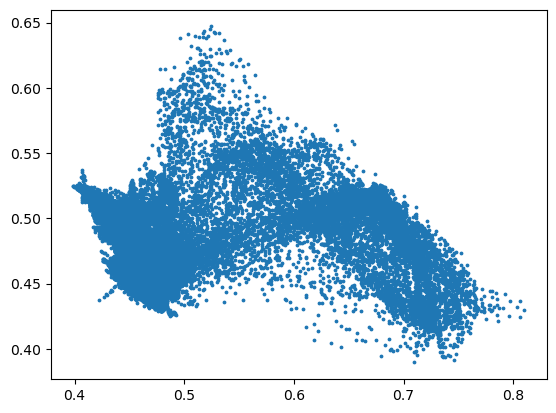

In [271]:
pc_1d = pc.reshape(-1, 10)
plt.scatter(pc_1d[:,0], pc_1d[:,1], s = 3)

In [272]:
kmeans_p = get_kmeans_clusters(pc, num_clusters=2)
print(kmeans_p.shape)

(480, 640)


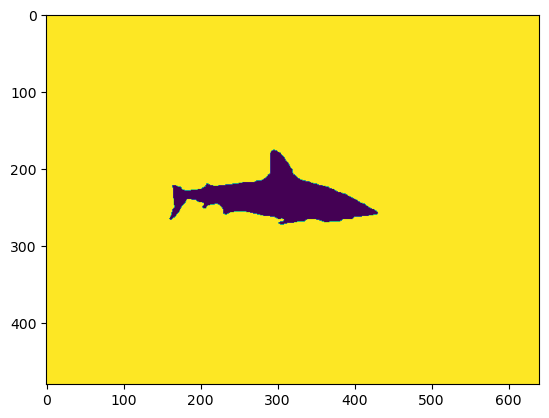

In [273]:
plt.imshow(kmeans_p)

In [274]:
annot_features, targets = get_vgg16_features_targets(img, labels, layer_list=[0], scalings=[1,2], model_name="vgg16")
print(annot_features.shape)
print(targets.shape)

Using RGB
(2480, 128)
(2480,)


In [275]:
pc_annot = get_pca_features(annot_features, num_components=10)
print(pc_annot.shape)

(2480, 10)


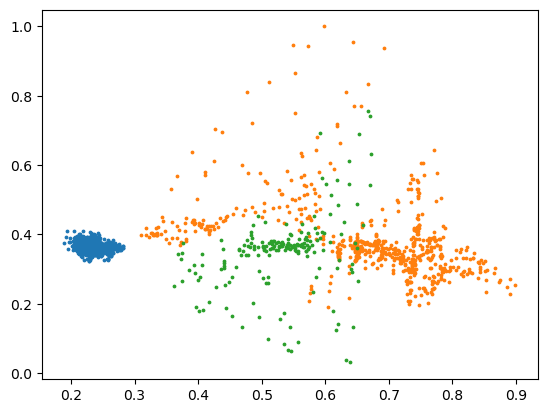

In [276]:
for c in np.unique(targets):
    plt.scatter(pc_annot[targets == c,0], pc_annot[targets == c,1], s = 3)

## DINOv2

In [277]:
used_model = "s_r"
# used_model = "uni"

In [278]:
# # For use of the UNI model, we need to login to the Hugging Face Hub with access to the model
# hf_token = input("paste your huggingface token here: ")
# from huggingface_hub import login; login(hf_token)

In [279]:
patch_features = get_dinov2_patch_features(img, dinov2_model=used_model)
print(patch_features.shape)

(1610, 384)


In [280]:
pix_features = get_dinov2_pixel_features(img, interpolate_features=False, dinov2_model=used_model)
print(pix_features.shape)

(307200, 384)


In [281]:
feature_space = get_dinov2_feature_space(img, interpolate_features=False, dinov2_model=used_model)
print(feature_space.shape)

(480, 640, 384)


In [282]:
v.add_image(np.moveaxis(feature_space, -1, 0), name=f"Feature Space DINOv2 ({used_model})")

<Image layer 'Feature Space DINOv2 (s_r)' at 0x205492d94c0>

In [283]:
kmeans_f = get_kmeans_clusters(feature_space, num_clusters=2)
print(kmeans_f.shape)

(480, 640)


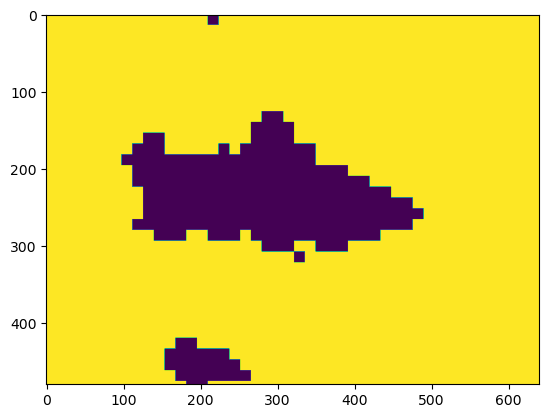

In [284]:
plt.imshow(kmeans_f)

In [285]:
pc = get_pca_features(feature_space, num_components=10)
print(pc.shape)

(480, 640, 10)


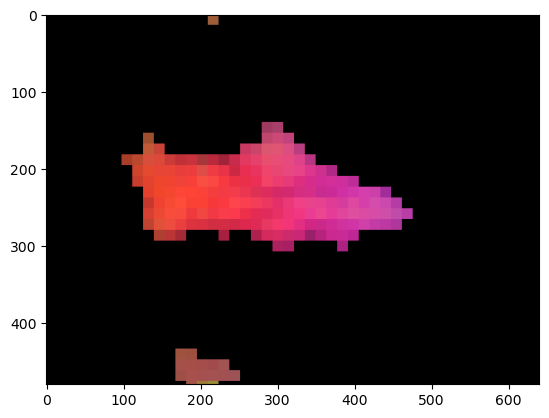

In [286]:
three_pc = pc[:,:,:3].copy()
pc_mask = pc[:,:,0]<0.6
three_pc[pc_mask] = 0
plt.imshow(three_pc)

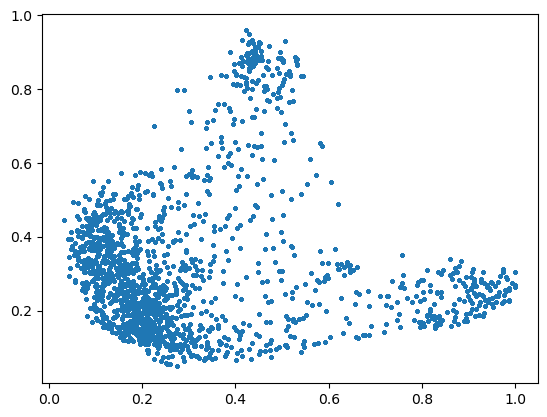

In [287]:
pc_1d = pc.reshape(-1, 10)
plt.scatter(pc_1d[:,0], pc_1d[:,1], s = 3)

In [288]:
kmeans_p = get_kmeans_clusters(pc, num_clusters=2)
print(kmeans_p.shape)

(480, 640)


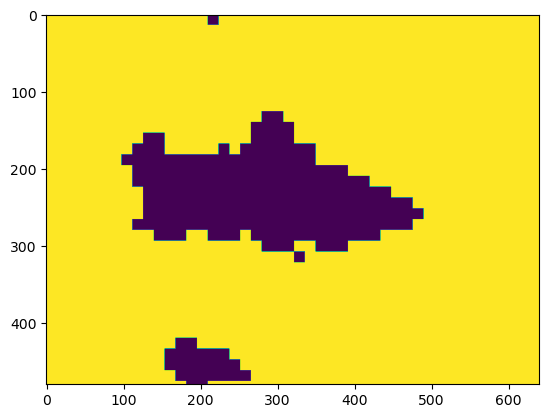

In [289]:
plt.imshow(kmeans_p)

In [290]:
annot_features, targets = get_dinov2_features_targets(img, labels, interpolate_features=False)
print(annot_features.shape)
print(targets.shape)

(2480, 384)
(2480,)


In [291]:
pc_annot = get_pca_features(annot_features, num_components=10)
print(pc_annot.shape)

(2480, 10)


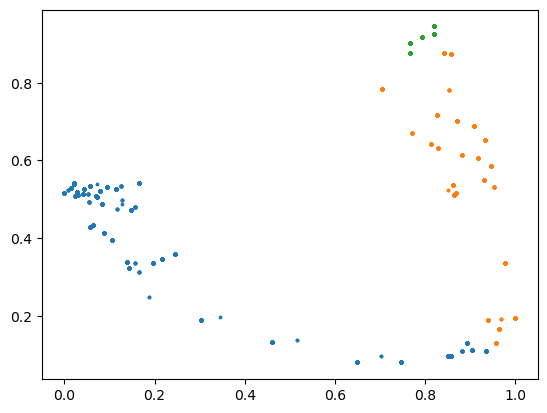

In [292]:
for c in np.unique(targets):
    plt.scatter(pc_annot[targets == c,0], pc_annot[targets == c,1], s = 3)

## Ilastik

In [293]:
feature_space = get_ila_feature_space(img)
print(feature_space.shape)

(480, 640, 168)


In [294]:
v.add_image(np.moveaxis(feature_space, -1, 0), name="Feature Space Ilastik")

<Image layer 'Feature Space Ilastik' at 0x20555e9cfd0>

In [295]:
kmeans_f = get_kmeans_clusters(feature_space, num_clusters=2)
print(kmeans_f.shape)

(480, 640)


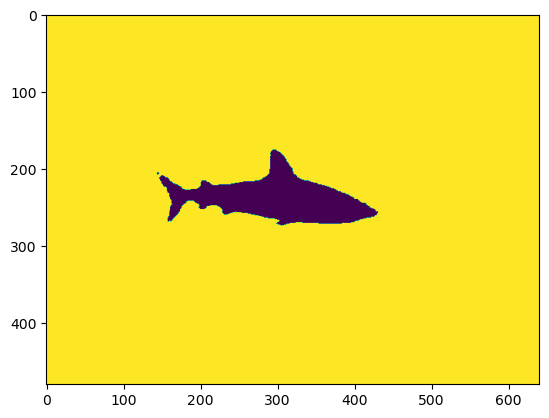

In [296]:
plt.imshow(kmeans_f)

In [297]:
pc = get_pca_features(feature_space, num_components=10)
print(pc.shape)

(480, 640, 10)


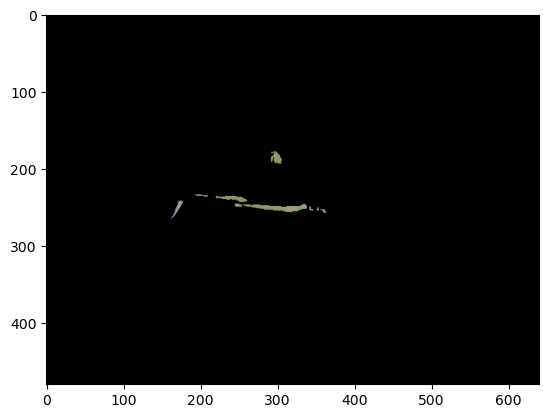

In [298]:
three_pc = pc[:,:,:3].copy()
pc_mask = pc[:,:,0]<0.5
three_pc[pc_mask] = 0
plt.imshow(three_pc)

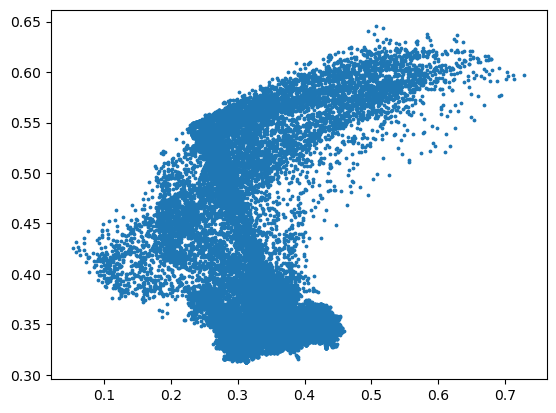

In [299]:
pc_1d = pc.reshape(-1, 10)
plt.scatter(pc_1d[:,0], pc_1d[:,1], s = 3)

In [300]:
kmeans_p = get_kmeans_clusters(pc, num_clusters=2)
print(kmeans_p.shape)

(480, 640)


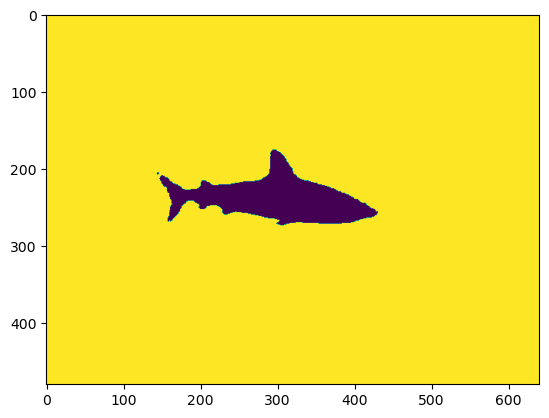

In [301]:
plt.imshow(kmeans_p)

In [302]:
annot_features, targets = get_ila_features_targets(img, labels)

In [303]:
pc_annot = get_pca_features(annot_features, num_components=10)
print(pc_annot.shape)

(2480, 10)


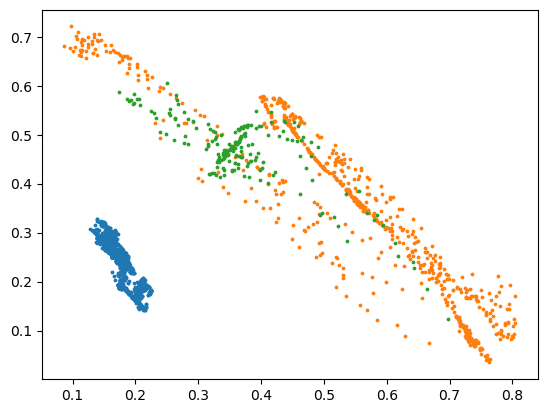

In [304]:
for c in np.unique(targets):
    plt.scatter(pc_annot[targets == c,0], pc_annot[targets == c,1], s = 3)

## Test random forest functions

In [305]:
# features_func_train = get_vgg16_features_targets
# features_func_pred = get_vgg16_feature_space
# features_cfg = {"layer_list": [0], "scalings": [1,2], "model_name": "vgg16"}
features_func_train = get_dinov2_features_targets
features_func_pred = get_dinov2_feature_space
# features_func_pred = get_dinov2_pixel_features
# features_func_pred = get_dinov2_patch_features
features_cfg = {"pc": 0, "dinov2_model":"s_r"}
# features_func_train = get_ila_features_targets
# features_func_pred = get_ila_feature_space
# features_cfg = {}

In [306]:
# # For use of the UNI model, we need to login to the Hugging Face Hub with access to the model
# hf_token = input("paste your huggingface token here: ")
# from huggingface_hub import login; login(hf_token)

In [307]:
rf = train_seg_forest([img], [labels], features_func_train, features_cfg, print_steps=True, random_state=0)

Extracting features for labels 1/1 - estimated time left: NA


In [308]:
pred = predict_seg_forest_single_image(img, rf, features_func_pred, features_cfg, pred_per_patch=False, patch_size=(14,14))
print(pred.shape)

(480, 640)


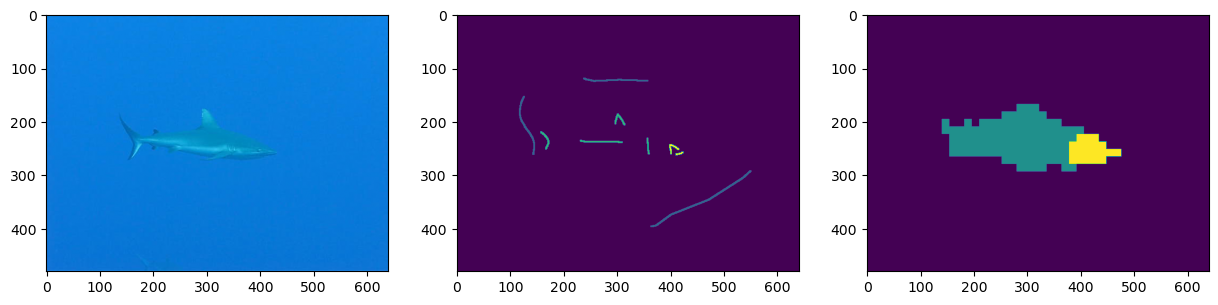

In [309]:
fig, ax = plt.subplots(1,3, figsize = (15,5))

ax[0].imshow(img)
ax[1].imshow(labels)
ax[2].imshow(pred)

In [310]:
pred_vid = shark_vid.copy()/255
pred_vid = pred_vid[:40:4]

In [311]:
v2 = napari.view_image(pred_vid)

In [312]:
pred_batch = predict_seg_forest(pred_vid, rf, features_func_pred, features_cfg, pred_per_patch=False, patch_size=(14,14), print_steps=True)

Predicting image 1/10 - estimated time left: NA
Predicting image 2/10 - estimated time left: 54.4 seconds
Predicting image 3/10 - estimated time left: 42.9 seconds
Predicting image 4/10 - estimated time left: 36.8 seconds
Predicting image 5/10 - estimated time left: 30.8 seconds
Predicting image 6/10 - estimated time left: 25.3 seconds
Predicting image 7/10 - estimated time left: 20.1 seconds
Predicting image 8/10 - estimated time left: 15.2 seconds
Predicting image 9/10 - estimated time left: 10.0 seconds
Predicting image 10/10 - estimated time left: 5.0 seconds


In [313]:
v2.add_labels(pred_batch)

<Labels layer 'pred_batch' at 0x205ae488670>